## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regularizer=l1_l2, ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizer(ratio))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizer(ratio))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8]
Dropout_EXP = [0.25, 0.5, 0.75]

In [16]:
results = {}

for regulizer_ratio in L1_L2_EXP:
    for dropout_ratio in Dropout_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer %.6f"%(regulizer_ratio) + "Dropout_ratio %.6f"%(dropout_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], ratio = regulizer_ratio, drp_ratio = dropout_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-l1_l2-%s"%str(regulizer_ratio) +"/"+ str(dropout_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with Regulizer 0.010000Dropout_ratio 0.250000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dr

Epoch 43/50
50000/50000 [==============================] - 13s 262us/step - loss: 2.3415 - accuracy: 0.3316 - val_loss: 2.6112 - val_accuracy: 0.2323
Epoch 44/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.3387 - accuracy: 0.3258 - val_loss: 3.2504 - val_accuracy: 0.1307
Epoch 45/50
50000/50000 [==============================] - 13s 263us/step - loss: 2.3114 - accuracy: 0.3259 - val_loss: 2.6333 - val_accuracy: 0.2436
Epoch 46/50
50000/50000 [==============================] - 13s 258us/step - loss: 2.2916 - accuracy: 0.3374 - val_loss: 2.6695 - val_accuracy: 0.2329
Epoch 47/50
50000/50000 [==============================] - 13s 261us/step - loss: 2.3160 - accuracy: 0.3304 - val_loss: 2.6426 - val_accuracy: 0.2187
Epoch 48/50
50000/50000 [==============================] - 13s 260us/step - loss: 2.3047 - accuracy: 0.3362 - val_loss: 2.3303 - val_accuracy: 0.3037
Epoch 49/50
50000/50000 [==============================] - 13s 254us/step - loss: 2.3125 - accuracy:

Epoch 35/50
50000/50000 [==============================] - 13s 255us/step - loss: 2.4325 - accuracy: 0.2700 - val_loss: 2.4982 - val_accuracy: 0.2491
Epoch 36/50
50000/50000 [==============================] - 13s 251us/step - loss: 2.4593 - accuracy: 0.2590 - val_loss: 2.4113 - val_accuracy: 0.2600
Epoch 37/50
50000/50000 [==============================] - 13s 252us/step - loss: 2.4407 - accuracy: 0.2689 - val_loss: 2.8343 - val_accuracy: 0.1751
Epoch 38/50
50000/50000 [==============================] - 12s 247us/step - loss: 2.4301 - accuracy: 0.2728 - val_loss: 2.3225 - val_accuracy: 0.3125
Epoch 39/50
50000/50000 [==============================] - 12s 249us/step - loss: 2.4229 - accuracy: 0.2685 - val_loss: 2.5824 - val_accuracy: 0.2283
Epoch 40/50
50000/50000 [==============================] - 12s 247us/step - loss: 2.4257 - accuracy: 0.2644 - val_loss: 2.9909 - val_accuracy: 0.1454
Epoch 41/50
50000/50000 [==============================] - 12s 246us/step - loss: 2.4462 - accuracy:

Epoch 27/50
50000/50000 [==============================] - 14s 286us/step - loss: 2.5786 - accuracy: 0.2145 - val_loss: 2.5657 - val_accuracy: 0.2054
Epoch 28/50
50000/50000 [==============================] - 16s 323us/step - loss: 2.5947 - accuracy: 0.2131 - val_loss: 2.5752 - val_accuracy: 0.2127
Epoch 29/50
50000/50000 [==============================] - 18s 362us/step - loss: 2.5766 - accuracy: 0.2134 - val_loss: 2.5044 - val_accuracy: 0.2553
Epoch 30/50
50000/50000 [==============================] - 15s 301us/step - loss: 2.5665 - accuracy: 0.2200 - val_loss: 2.5317 - val_accuracy: 0.2456
Epoch 31/50
50000/50000 [==============================] - 17s 335us/step - loss: 2.5607 - accuracy: 0.2166 - val_loss: 2.5387 - val_accuracy: 0.2385
Epoch 32/50
50000/50000 [==============================] - 16s 323us/step - loss: 2.5641 - accuracy: 0.2105 - val_loss: 3.0230 - val_accuracy: 0.1259
Epoch 33/50
50000/50000 [==============================] - 15s 305us/step - loss: 2.5727 - accuracy:

50000/50000 [==============================] - 14s 288us/step - loss: 10.4334 - accuracy: 0.4547 - val_loss: 10.1988 - val_accuracy: 0.4763
Epoch 19/50
50000/50000 [==============================] - 16s 312us/step - loss: 10.0590 - accuracy: 0.4635 - val_loss: 9.8312 - val_accuracy: 0.4801
Epoch 20/50
50000/50000 [==============================] - 21s 429us/step - loss: 9.7011 - accuracy: 0.4673 - val_loss: 9.4854 - val_accuracy: 0.4838
Epoch 21/50
50000/50000 [==============================] - 17s 341us/step - loss: 9.3576 - accuracy: 0.4711 - val_loss: 9.1646 - val_accuracy: 0.4798
Epoch 22/50
50000/50000 [==============================] - 16s 327us/step - loss: 9.0272 - accuracy: 0.4739 - val_loss: 8.8612 - val_accuracy: 0.4762
Epoch 23/50
50000/50000 [==============================] - 15s 300us/step - loss: 8.7110 - accuracy: 0.4776 - val_loss: 8.5343 - val_accuracy: 0.4902
Epoch 24/50
50000/50000 [==============================] - 14s 283us/step - loss: 8.4044 - accuracy: 0.4790 -

Epoch 10/50
50000/50000 [==============================] - 14s 285us/step - loss: 14.2643 - accuracy: 0.3225 - val_loss: 13.8519 - val_accuracy: 0.3787
Epoch 11/50
50000/50000 [==============================] - 14s 288us/step - loss: 13.7436 - accuracy: 0.3312 - val_loss: 13.3529 - val_accuracy: 0.3845
Epoch 12/50
50000/50000 [==============================] - 16s 311us/step - loss: 13.2454 - accuracy: 0.3417 - val_loss: 12.8859 - val_accuracy: 0.3895
Epoch 13/50
50000/50000 [==============================] - 17s 341us/step - loss: 12.7623 - accuracy: 0.3471 - val_loss: 12.4196 - val_accuracy: 0.3930
Epoch 14/50
50000/50000 [==============================] - 16s 318us/step - loss: 12.3089 - accuracy: 0.3529 - val_loss: 11.9595 - val_accuracy: 0.3993
Epoch 15/50
50000/50000 [==============================] - 15s 301us/step - loss: 11.8747 - accuracy: 0.3580 - val_loss: 11.5311 - val_accuracy: 0.4058
Epoch 16/50
50000/50000 [==============================] - 16s 327us/step - loss: 11.449

Epoch 2/50
50000/50000 [==============================] - 15s 297us/step - loss: 20.4807 - accuracy: 0.1323 - val_loss: 18.9845 - val_accuracy: 0.1451
Epoch 3/50
50000/50000 [==============================] - 14s 283us/step - loss: 19.3499 - accuracy: 0.1487 - val_loss: 18.2262 - val_accuracy: 0.2041
Epoch 4/50
50000/50000 [==============================] - 15s 291us/step - loss: 18.4069 - accuracy: 0.1600 - val_loss: 17.5449 - val_accuracy: 0.2298
Epoch 5/50
50000/50000 [==============================] - 15s 293us/step - loss: 17.5872 - accuracy: 0.1677 - val_loss: 16.9300 - val_accuracy: 0.2303
Epoch 6/50
50000/50000 [==============================] - 14s 284us/step - loss: 16.8438 - accuracy: 0.1807 - val_loss: 16.3409 - val_accuracy: 0.2305
Epoch 7/50
50000/50000 [==============================] - 14s 284us/step - loss: 16.1833 - accuracy: 0.1885 - val_loss: 15.7747 - val_accuracy: 0.2333
Epoch 8/50
50000/50000 [==============================] - 14s 284us/step - loss: 15.5730 - acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 15s 303us/step - loss: 16.4059 - accuracy: 0.2023 - val_loss: 15.6824 - val_accuracy: 0.2175
Epoch 2/50
50000/50000 [==============================] - 14s 279us/step - loss: 15.4696 - accuracy: 0.2914 - val_loss: 15.0595 - val_accuracy: 0.2556
Epoch 3/50
50000/50000 [==============================] - 17s 337us/step - loss: 14.8125 - accuracy: 0.3200 - val_loss: 14.4247 - val_accuracy: 0.3384
Epoch 4/50
50000/50000 [==============================] - 14s 286us/step - loss: 14.2299 - accuracy: 0.3416 - val_loss: 13.8756 - val_accuracy: 0.3631
Epoch 5/50
50000/50000 [==============================] - 14s 289us/step - loss: 13.6992 - accuracy: 0.3517 - val_loss: 13.3636 - val_accuracy: 0.3756
Epoch 6/50
50000/50000 [==============================] - 14s 282us/step - loss: 13.1920 - accuracy: 0.3662 - val_loss: 12.8793 - val_accuracy: 0.3860
Epoch 7/50
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 318us/step - loss: 16.9476 - accuracy: 0.1494 - val_loss: 15.8010 - val_accuracy: 0.1551
Epoch 2/50
50000/50000 [==============================] - 15s 291us/step - loss: 15.9724 - accuracy: 0.2116 - val_loss: 15.1418 - val_accuracy: 0.2188
Epoch 3/50
50000/50000 [==============================] - 13s 258us/step - loss: 15.2348 - accuracy: 0.2358 - val_loss: 14.4931 - val_accuracy: 0.3117
Epoch 4/50
50000/50000 [==============================] - 12s 248us/step - loss: 14.5894 - accuracy: 0.2532 - val_loss: 13.9819 - val_accuracy: 0.3307
Epoch 5/50
50000/50000 [==============================] - 12s 247us/step - loss: 14.0142 - accuracy: 0.2687 - val_loss: 13.4609 - val_accuracy: 0.3382
Epoch 6/50
50000/50000 [==============================] - 12s 247us/step - loss: 13.4823 - accuracy: 0.2791 - val_loss: 12.9898 - val_accuracy: 0.3487
Epoch 7/50
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 257us/step - loss: 17.9828 - accuracy: 0.1075 - val_loss: 15.8349 - val_accuracy: 0.1137
Epoch 2/50
50000/50000 [==============================] - 12s 241us/step - loss: 16.7707 - accuracy: 0.1299 - val_loss: 15.3001 - val_accuracy: 0.1427
Epoch 3/50
50000/50000 [==============================] - 12s 244us/step - loss: 15.7881 - accuracy: 0.1444 - val_loss: 14.7048 - val_accuracy: 0.2063
Epoch 4/50
50000/50000 [==============================] - 12s 243us/step - loss: 14.9935 - accuracy: 0.1579 - val_loss: 14.1832 - val_accuracy: 0.2385
Epoch 5/50
50000/50000 [==============================] - 12s 247us/step - loss: 14.3113 - accuracy: 0.1672 - val_loss: 13.7045 - val_accuracy: 0.2435
Epoch 6/50
50000/50000 [==============================] - 12s 247us/step - loss: 13.7179 - accuracy: 0.1763 - val_loss: 13.2489 - val_accuracy: 0.2393
Epoch 7/50
50000/50000 [====================

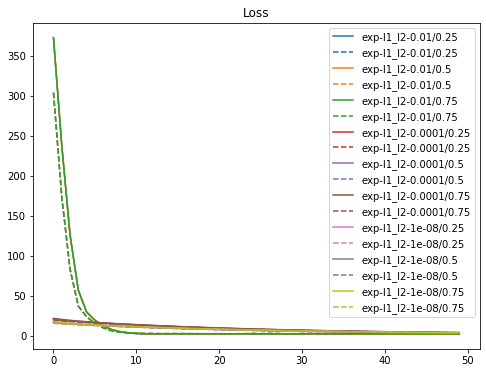

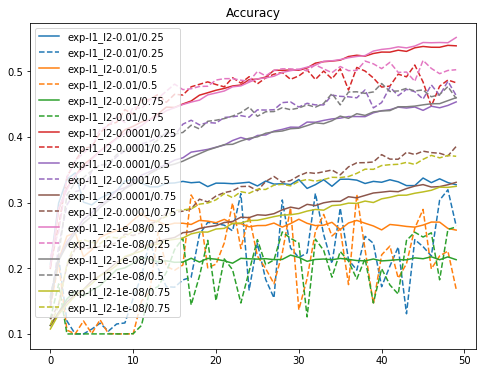

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = []
for i in range(0,9):
    color_bar.append('C' + str(i))

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'],'-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'],'--', label=cond, color=color_bar[i])
plt.legend()
plt.title("Loss")
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'],'-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'],'--', label=cond, color=color_bar[i])
plt.legend()
plt.title("Accuracy")
plt.show()